# Anime Recommendation Systems

## Imports, checking and cleaning

### Import Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import sys
from scipy.sparse import csr_matrix
import warnings
import joblib
import pickle
from fastparquet import write
from fuzzywuzzy import fuzz


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## scikit modeling libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics.pairwise import sigmoid_kernel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#Preparing folder variables
main_folder = sys.path[0]
data_folder = (main_folder + "\data")
saved_models_folder = (data_folder + "\saved_models")
sounds_folder = (main_folder + "\sounds")
saved_models = (main_folder + "\saved_models")
processed_data = (data_folder + "\processed")
sounds_folder = (main_folder + "\sounds")

### Loading the data

In [2]:
animedf = pd.read_csv(data_folder + "/" + "anime.csv")
ratingdf = pd.read_csv(data_folder + "/" + "rating.csv.zip")

In [28]:
ratingdf.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Let's check information of anime dataset

In [29]:
animedf.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


In [30]:
animedf.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [31]:
print ("The shape of the anime data is (row, column):"+ str(animedf.shape))
print (animedf.info())

The shape of the anime data is (row, column):(12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


### Let's check information of rating dataset

In [32]:
print ("The shape of the rating data is (row, column):"+ str(animedf.shape))
print (ratingdf.info())

The shape of the rating data is (row, column):(12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


##### Merging dataframes

In [9]:
# Cambiamos a minúsculas todos los nombre de animes
animedf['name'] = animedf['name'].str.lower()

# Añadimos suffixes for ratingdf ya que en los dos df la columna rating tiene el mismo nombre
merged_df=pd.merge(animedf,ratingdf,on='anime_id',suffixes= ['', '_user']) 

# Cambiamos un par de nombres de columnas
merged_df = merged_df.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})

merged_df.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   anime_title  object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


### Handling NaN values

In [35]:
merged_df.isnull().sum()

anime_id         0
anime_title      0
genre          110
type             4
episodes         0
rating           6
members          0
user_id          0
user_rating      0
dtype: int64

In [10]:
merged_df['genre'].fillna(merged_df['genre'].mode()[0], inplace=True)

In [11]:
merged_df['type'].fillna(merged_df['type'].mode()[0], inplace=True)

In [12]:
merged_df['rating'] = merged_df['rating'].interpolate(method = "spline", order = 1,  limit_direction = "both", downcast = "infer")

### Removing user_rating with no rating

In [13]:
#Replacing -1 values in user_rating column for Nan values
merged_df["user_rating"].replace({-1: np.nan}, inplace=True)

In [40]:
merged_df.isnull().sum()

anime_id             0
anime_title          0
genre                0
type                 0
episodes             0
rating               0
members              0
user_id              0
user_rating    1476488
dtype: int64

In [14]:
#Droping NaN values
merged_df = merged_df.dropna(axis = 0, how ='any') 

In [42]:
merged_df.isnull().sum()

anime_id       0
anime_title    0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
dtype: int64

C:\Users\christiandda\AppData\Local\Temp\ipykernel_18996\3155341435.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


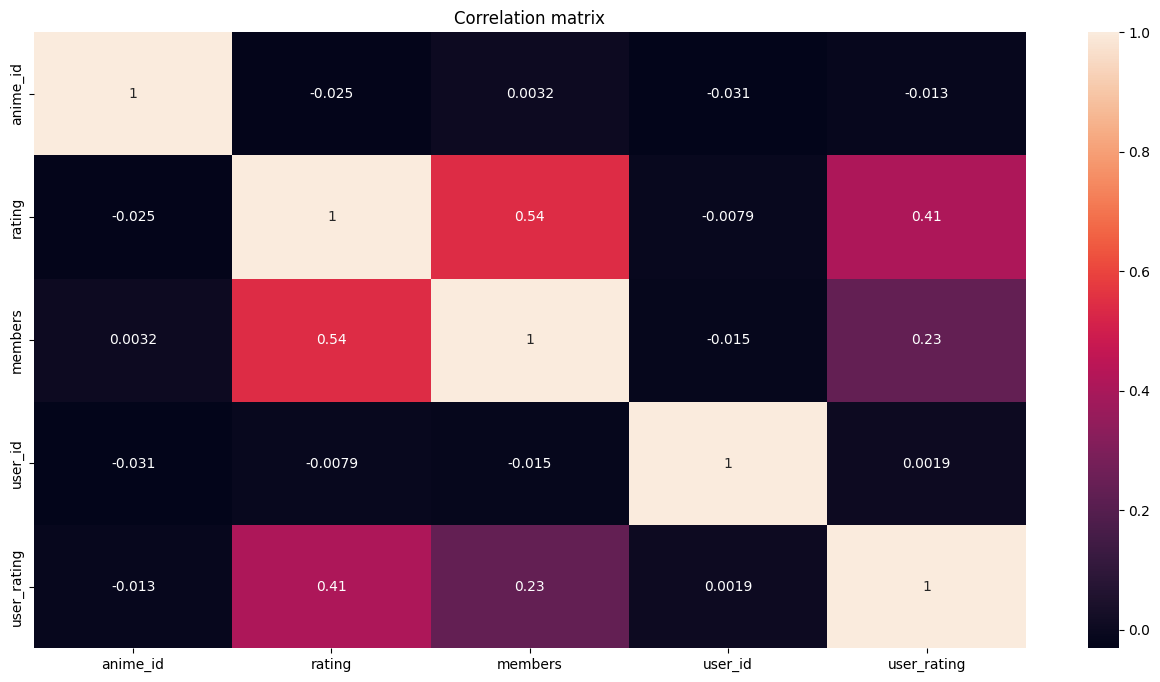

In [43]:
# Checking possible correlations for future studies.
plt.rc("figure", figsize=(16,8))
corr = merged_df.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()
plt.close()# Close the plot

## Building The Recommendation Systems

User-based: (Este es el que veremos a continuación)
- Se identifican usuarios similares
- Se recomiendan nuevos ítems a otros usuarios basado en el rating dado por otros usuarios similares (que no haya valorado este usuario)

## Collaborative Filtering

### Cosine Similarity using KNN

In [15]:
features=merged_df.copy()

features.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
5,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0


#### Checking user_id iformation

In [16]:
features['user_id'].value_counts()
counts = features['user_id'].value_counts()
features = features[features['user_id'].isin(counts[counts >= 20].index)]

In [57]:
features.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
2,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
7,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8.0
11,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,598,10.0
14,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,784,9.0


In [59]:
features.shape

(3179775, 9)

#### Pivoting

In [47]:
from fastparquet import write 
pivot_df=features.pivot_table(index='anime_title',columns='user_id',values='user_rating').fillna(0)
pivot_df.head()


user_id                                              5      7      17     \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              38     43     46     \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              123    129    139    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              160    210    226    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    7.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     8.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       8.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              233    235    244    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              248    250    256    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              261    271    282    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu: hatsukoi    0.0    0.0    0.0   
&quot;bungaku shoujo&quot; memoire                     0.0    0.0    0.0   
&quot;bungaku shoujo&quot; movie                       0.0    0.0    0.0   
&quot;eiji&quot;                                       0.0    0.0    0.0   

user_id                                              288    294    301    \
anime_title                                                                
&quot;0&quot;                                          0.0    0.0    0.0   
&quot;bungaku shoujo&quot; kyou no oyatsu

In [51]:
import pickle
fichero = open(processed_data + "/" +"pivot_df.pkl","wb")
pickle.dump(pivot_df,fichero)
fichero.close()

## Opening cleaned df using Pickle

In [80]:
fichero = open(processed_data + "/" +"pivot_df.pkl","rb")
pivot_df = pickle.load(fichero)
fichero.close()

In [52]:
pivot_df.shape

(9819, 8713)

#### Creating matrix and fitting the model

In [18]:
from sklearn.model_selection import GridSearchCV
matrix = csr_matrix(pivot_df.values)

In [1]:
import pickle
fichero = open(processed_data + "/" +"matrix.pkl","wb")
pickle.dump(matrix,fichero)
fichero.close()

NameError: name 'processed_data' is not defined

In [4]:
fichero = open(processed_data + "/" +"matrix.pkl","rb")
matrix = pickle.load(fichero)
fichero.close()

In [90]:
parametros = { 'n_neighbors' : range(1,10),
               'radius' : np.linspace(0,1,11),
               'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
			   'leaf_size' : [30],
			   'metric' : ['minkowski','euclidean','manhattan'],
			   'p' : range(1,2)
			   }
scoring = ['accuracy','average_precision','top_k_accuracy','balanced_accuracy']

In [91]:
model_knn = GridSearchCV(NearestNeighbors(), parametros, scoring=scoring, 
                          refit='accuracy', return_train_score=True,cv =3, n_jobs = -1)

In [84]:
model_knn = GridSearchCV(NearestNeighbors(), parametros, scoring="accuracy",refit='precision_score', cv=2, n_jobs = -1,)

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'deep'

In [ ]:
model_knn.fit(matrix)

In [107]:

distances, indices = model_knn.kneighbors(matrix)

print(indices)
print(distances)
print(model_knn.kneighbors_graph(X).toarray())


In [7]:
model_knn = NearestNeighbors(n_neighbors=2,metric = 'euclidean', algorithm = 'brute',p=2) # REVISAR EUCLEDIANA, ME VENDRIA MEJOR
model_knn.fit(matrix)

distances, indices = model_knn.kneighbors(matrix)

df_ind = pd.DataFrame(data=indices)



In [ ]:
from fastparquet import write
write(processed_data + "/" + "df_ind_n2.parq", df_ind)

In [96]:
df_ind = pd.read_parquet(processed_data + "/" + "df_ind.parq", engine='fastparquet')


#### Getting recommendation

In [91]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(pivot_df.index[index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, pivot_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for himitsu no akko-chan 2:

1: akaneiro ni somaru saka: hardcore, with distance of 245.32427519509764:
2: tayutama: kiss on my deity, with distance of 281.1263061330263:
3: goshuushou-sama ninomiya-kun, with distance of 286.174771774173:
4: akikan!, with distance of 287.53956249531996:
5: fortune arterial: akai yakusoku, with distance of 292.77978072264483:
6: nogizaka haruka no himitsu: purezza, with distance of 294.4893886033926:
7: final approach, with distance of 295.1762185542731:
8: hoshizora e kakaru hashi, with distance of 295.8361032734173:
9: kimi ga aruji de shitsuji ga ore de, with distance of 296.5299310356376:


In [20]:
# model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
# model_knn.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [102]:
to_find_index.shape

(9819, 1)

In [164]:
to_find_index=pivot_df.reset_index()
to_find_index = to_find_index[["anime_title"]]


# a function to convert index to title
def get_title_from_index(index):
   return to_find_index[to_find_index.index == index]['anime_title'].values[0]
get_title_from_index(196)


# a function to convert title to index
def get_index_from_title(title):
   return to_find_index[to_find_index.anime_title == title].index.values[0]

# create a function to find the closest title
def matching_score(a,b):
   return fuzz.ratio(a,b)

# a function to return the most similar title to the words a user type
def find_closest_title(title):
   leven_scores = list(enumerate(to_find_index['anime_title'].apply(matching_score, b=title)))
   sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
   closest_title = get_title_from_index(sorted_leven_scores[0][0])
   distance_score = sorted_leven_scores[0][1]
   return closest_title, distance_score


def reco(name,n):
    index = get_index_from_title(name)
    distances, indices = model_knn.kneighbors(pivot_df.iloc[index,:].values.reshape(1, -1), n_neighbors = n+1)
    for i in range(0, n+1):
        if i == 0:
            print('Recommendations for {0}:\n'.format(pivot_df.index[index]))
        else:
            print('{0}: {1}, with distance of {2}'.format(i, pivot_df.index[indices.flatten()[i]], distances.flatten()[i]))
        
def contents_based_recommender(movie_user_likes,number):
   lowertittle = movie_user_likes.lower() # Pasamos el titulo a minúsculas
   closest_title, distance_score = find_closest_title(lowertittle)
   # When a user does not make misspellings
   if distance_score == 100:
      return reco(movie_user_likes,number)
   # When a user makes misspellings    
   else:
      print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
      return reco(closest_title,number)


In [169]:
contents_based_recommender("bleach",20)

Recommendations for bleach:

1: naruto, with distance of 0.3377446541403397
2: bleach movie 4: jigoku-hen, with distance of 0.3626242262531838
3: ao no exorcist, with distance of 0.36878049421709524
4: fairy tail, with distance of 0.37182121426934756
5: bleach movie 3: fade to black - kimi no na wo yobu, with distance of 0.3761315640066828
6: sword art online, with distance of 0.3849580774157688
7: bleach movie 2: the diamonddust rebellion - mou hitotsu no hyourinmaru, with distance of 0.38754604866991327
8: bleach movie 1: memories of nobody, with distance of 0.3909598952371247
9: fullmetal alchemist: brotherhood, with distance of 0.4004186945617886
10: shingeki no kyojin, with distance of 0.4004459185285638
11: death note, with distance of 0.4030323875545072
12: highschool of the dead, with distance of 0.4124432499541335
13: deadman wonderland, with distance of 0.42234017421354264
14: guilty crown, with distance of 0.4319263631644268
15: mirai nikki (tv), with distance of 0.433497946

In [162]:
contents_based_recommender("Naruto")

TypeError: contents_based_recommender() missing 1 required positional argument: 'number'

In [163]:
contents_based_recommender("naruto",2)

Recommendations for naruto:

1: death note, with distance of 0.2894634502219502:
2: sword art online, with distance of 0.3232479889000921:


## Content based filtering

El filtrado basado en el contenido, también denominado filtrado cognitivo, recomienda elementos basándose en una comparación entre el contenido de los elementos y un perfil de usuario. El contenido de cada artículo se representa como un conjunto de descriptores o términos, normalmente las palabras que aparecen en un documento. Un recomendador basado en el contenido trabaja con los datos que proporciona el usuario, ya sea explícitamente (valoración) o implícitamente (al hacer clic en un enlace). A partir de esos datos, se genera un perfil de usuario que se utiliza para hacerle sugerencias. A medida que el usuario proporciona más datos o realiza acciones sobre las recomendaciones, el motor se vuelve cada vez más preciso.

### TF-IDF

#### Ajustando el nombre de la columna anime_title

In [51]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

animedf['name'] = animedf['name'].apply(text_cleaning)

#### TfidfVectorizer

TF es simplemente la frecuencia de una palabra en un documento. IDF es la inversa de la frecuencia de documentos entre todo el corpus de documentos. TF-IDF se utiliza principalmente por dos razones: Supongamos que buscamos "the rise of analytics" en Google. Es cierto que "the" aparecerá con más frecuencia que "analytics", pero la importancia relativa de analytics es mayor desde el punto de vista de la consulta de búsqueda. En estos casos, la ponderación TF-IDF anula el efecto de las palabras de alta frecuencia a la hora de determinar la importancia de un elemento (documento).

Aquí vamos a utilizarlo en el género para poder recomendar a los usuarios en función del contenido del género.

In [52]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
animedf['genre'] = animedf['genre'].fillna('')
genres_str = animedf['genre'].str.split(',').astype(str)
tfv_matrix = tfv.fit_transform(genres_str)

In [29]:
animedf.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,fullmetal alchemist: brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665


In [53]:
tfv_matrix.shape

(12294, 1554)

#### Calcular el kernel sigmoide

Scikit-learn ya proporciona métricas por pares (también conocidas como kernels en el lenguaje del aprendizaje automático) que funcionan tanto para representaciones densas como dispersas de colecciones de vectores. Aquí tenemos que asignar 1 al anime recomendado y 0 al anime no recomendado. Para ello utilizamos el kernel sigmoide

In [119]:
sig = sigmoid_kernel(tfv_matrix)
sig

array([[0.76186428, 0.76160041, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76160041, 0.76186428, 0.76160105, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76160105, 0.76186428, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76186428, 0.76186428,
        0.76186428],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76186428, 0.76186428,
        0.76186428],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76186428, 0.76186428,
        0.76186428]])

In [72]:
# Ya tenemos los índices para anime_title, ahora pasemos a averiguar el anime recomendado
indices = pd.Series(animedf.index, index=animedf['name']).drop_duplicates()

In [28]:
animedf.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,kimi no na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,fullmetal alchemist: brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665


otra forma es con La función de similitud del coseno calculará las similitudes entre pares de todas los animes de nuestra matriz de vectores. Podemos determinar el número de comparaciones por pares con la fórmula k²/2, siendo k el número de elementos de la matriz vectorial.

In [112]:
# calcular la matriz de similitud coseno
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(tfv_matrix)
similarity

array([[1.        , 0.02312668, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02312668, 1.        , 0.02549423, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02549423, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [122]:
from sklearn.metrics.pairwise import linear_kernel
sim_matrix = linear_kernel(tfv_matrix, tfv_matrix)

#### Función de recomendación

In [125]:
def give_rec(title,times, sig=sim_matrix):
    # Obtener el índice correspondiente a original_title
    lowertittle = title.lower() # Pasamos el titulo a minúsculas
    idx = int(indices[lowertittle]) #indice del título

    # Obtener las puntuaciones de similitud pairwsie 
    sig_scores = list(enumerate(sig[idx]))

    # Ordenar los animes
    sig_scores = sorted(sig_scores, key=lambda x: x[1] , reverse=True)

    # Puntuaciones de las 10 animes/películas más parecidas
    sig_scores = sig_scores[1:times+2]

    # Anime indices
    anime_indices = [i[0] for i in sig_scores if i[0]!=idx ] # hay que decirle que no muestro el mismo anime que se ha escrito

    # Los 10 animes más parecidos
    return pd.DataFrame({'Anime name': animedf['name'].iloc[anime_indices].values})

In [126]:
give_rec('Naruto',20)

,Anime name
0,naruto: shippuuden
1,boruto: naruto the movie - naruto ga hokage ni natta hi
2,naruto x ut
3,naruto: shippuuden movie 4 - the lost tower
4,naruto: shippuuden movie 3 - hi no ishi wo tsugu mono
5,naruto shippuuden: sunny side battle
6,naruto soyokazeden movie: naruto to mashin to mitsu no onegai dattebayo!!
7,battle spirits: ryuuko no ken
8,kyutai panic adventure!
9,ranma ½: akumu! shunmin kou


In [123]:
def give_rec(title,times, sig=sig):
    # Obtener el índice correspondiente a original_title
    lowertittle = title.lower() # Pasamos el titulo a minúsculas
    idx = int(indices[lowertittle]) #indice del título

    # Obtener las puntuaciones de similitud pairwsie 
    sig_scores = list(enumerate(sig[idx]))

    # Ordenar los animes
    sig_scores = sorted(sig_scores, key=lambda x: x[1] , reverse=True)

    # Puntuaciones de las 10 animes/películas más parecidas
    sig_scores = sig_scores[1:times+2]

    # Anime indices
    anime_indices = [i[0] for i in sig_scores if i[0]!=idx ] # hay que decirle que no muestro el mismo anime que se ha escrito

    # Los 10 animes más parecidos
    return pd.DataFrame({'Anime name': animedf['name'].iloc[anime_indices].values})

,Anime name
0,naruto: shippuuden
1,boruto: naruto the movie - naruto ga hokage ni natta hi
2,naruto x ut
3,naruto: shippuuden movie 4 - the lost tower
4,naruto: shippuuden movie 3 - hi no ishi wo tsugu mono
5,naruto shippuuden: sunny side battle
6,naruto soyokazeden movie: naruto to mashin to mitsu no onegai dattebayo!!
7,battle spirits: ryuuko no ken
8,kyutai panic adventure!
9,ranma ½: akumu! shunmin kou


In [113]:
def give_rec(title,times, cosine_sim=similarity):
    # Obtener el índice correspondiente a original_title
    lowertittle = title.lower() # Pasamos el titulo a minúsculas
    idx = int(indices[lowertittle]) #indice del título

    # Obtener las puntuaciones de similitud pairwsie 
    sig_scores = list(enumerate(cosine_sim[idx]))

    # Ordenar los animes
    sig_scores = sorted(sig_scores, key=lambda x: x[1] , reverse=True)

    # Puntuaciones de las 10 animes/películas más parecidas
    sig_scores = sig_scores[1:times+2]

    # Anime indices
    anime_indices = [i[0] for i in sig_scores if i[0]!=idx ] # hay que decirle que no muestro el mismo anime que se ha escrito

    # Los 10 animes más parecidos
    return pd.DataFrame({'Anime name': animedf['name'].iloc[anime_indices].values})

In [115]:
give_rec('Naruto',20)

,Anime name
0,naruto: shippuuden
1,boruto: naruto the movie - naruto ga hokage ni natta hi
2,naruto x ut
3,naruto: shippuuden movie 4 - the lost tower
4,naruto: shippuuden movie 3 - hi no ishi wo tsugu mono
5,naruto shippuuden: sunny side battle
6,naruto soyokazeden movie: naruto to mashin to mitsu no onegai dattebayo!!
7,battle spirits: ryuuko no ken
8,kyutai panic adventure!
9,ranma ½: akumu! shunmin kou
